In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import pickle
import matplotlib.pyplot as plt
from ipywidgets import interactive

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/data_scores_and_features.csv')
                                       
data_vintages_1 = pd.read_csv('/content/gdrive/My Drive/vintages_1.csv')

data_vintages_2 = pd.read_csv('/content/gdrive/My Drive/vintages_2.csv')

data_vintages = pd.concat([data_vintages_1, data_vintages_2])

data_vintages.dropna(subset=['user_id'])

data_vintages['statement_num'].unique()

data_vintages = data_vintages.drop([1246634])

data_vintages['statement_num'] = data_vintages['statement_num'].apply(lambda x : int(x))

df = df.drop([32506, 68471, 93755])

filename = '/content/gdrive/My Drive/model.sav'
model = pickle.load(open(filename, 'rb'))

features = [
            'max_util',
            'soc_dem_score',
            'other_util',
            'last_credit_time_years',
            'credits_4y',
            'avg_limit_mortgage',
            'min_limit_mfo',
            'close_balance_amt',
            'avg_active_time',
]

df['avg_active_time'] = df['avg_active_time'].fillna(df['avg_active_time'].median())
df['avg_limit_mortgage'] = -df['avg_limit_mortgage']
df['close_balance_amt'] = -df['close_balance_amt']
df['max_util'] = df['max_util'].clip(upper=2)

df['model_pd'] = model.predict_proba(df[features])[:,1]

df = df.sort_values(['model_pd'], ignore_index=True)
df['pd_bucket'] = np.minimum(df.index // (df.shape[0]//3),2)

data_vintages = data_vintages.merge(df[['user_id', 'pd_bucket', 'model_pd']], how='left', on='user_id').dropna()

### Кривая Def Rate

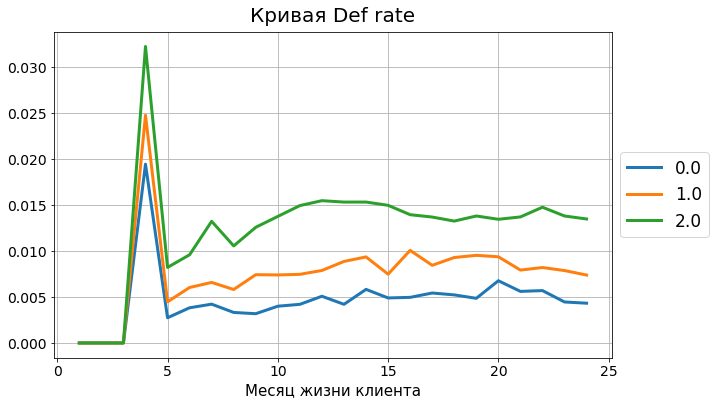

In [ ]:
data_vintages = data_vintages.eval('def_new_flg = def_flg * prev_act_flg', inplace=False)

def plot_def_rate_by_bucket(df, bucket):
    return (df.groupby([bucket, "statement_num"])
            .agg({"def_new_flg":np.sum, "prev_act_flg":np.sum, "user_id":np.count_nonzero})\
            .rename(columns = ({"def_new_flg":'def_cnt', "prev_act_flg":'prev_act_cnt', "user_id":"cnt"}))\
            .eval('def_rate = def_cnt / prev_act_cnt', inplace=False)\
            .unstack(bucket)
            ['def_rate']
            .plot(ax=None, figsize=(10, 6), grid=True, lw = 3))

plot_def_rate_by_bucket(data_vintages, 'pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Def rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Сглаженная полиномом кривая Def Rate

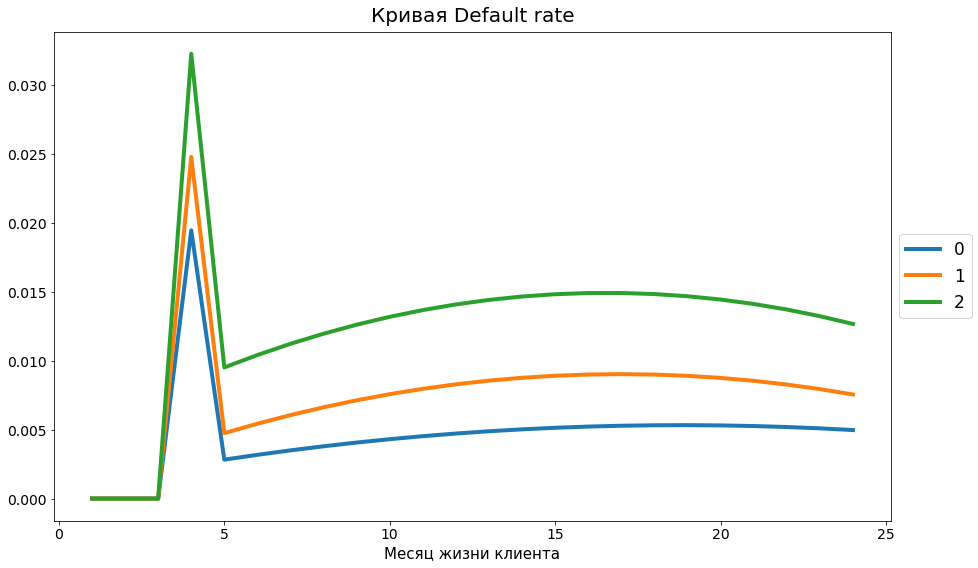

In [ ]:
def polynom_approximation(df, start=1, finish=20, degree = 1):
    df_res = pd.DataFrame(df)
    df_res['Полином'] = df['Среднее']                   
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)                                                 
    df_res.loc[start:finish, 'Полином'] = linear_coeff(np.arange(start, finish+1)) 
    df_res.loc[finish+1:, 'Полином'] = linear_coeff(finish+1)                    
    return df_res

default_rate_data = data_vintages.groupby(['pd_bucket', "statement_num"])\
    .agg({"def_new_flg":np.sum, "prev_act_flg":np.sum, "user_id":np.count_nonzero})\
    .rename(columns = ({"def_new_flg":'def_cnt', "prev_act_flg":'prev_act_cnt', "user_id":"cnt"}))\
    .eval('default_rate = def_cnt / prev_act_cnt', inplace=False)

default_rate_mean = default_rate_data.groupby(['statement_num', 'pd_bucket'])\
    .agg({'default_rate':np.mean})\
    .rename(columns = {'default_rate':'Среднее'})

buckets = df['pd_bucket'].drop_duplicates()

df_0_bucket = default_rate_mean.query('pd_bucket == 0').reset_index().set_index(['statement_num'])

df_1_bucket = default_rate_mean.query('pd_bucket == 1').reset_index().set_index(['statement_num'])

df_2_bucket = default_rate_mean.query('pd_bucket == 2').reset_index().set_index(['statement_num'])

df_polynom_0 = polynom_approximation(df_0_bucket, 5,24,2)

df_polynom_1 = polynom_approximation(df_1_bucket, 5,24,2)

df_polynom_2 = polynom_approximation(df_2_bucket, 5,24,2)

plt.figure(figsize=(15, 9))
df_polynom_0['Полином'].plot(lw = 4, label = '0')
df_polynom_1['Полином'].plot(lw = 4, label = '1')
df_polynom_2['Полином'].plot(lw = 4, label = '2')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Default rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)